In [1]:
import matplotlib.pyplot as plt
import numpy as np
import IPython
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_io as tfio
import functools
from pedalboard import load_plugin
from ReverberatorEstimator import layers, loss
import warnings
warnings.filterwarnings('ignore')
import time
import os

2021-11-17 15:06:01.017998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 15:06:01.018024: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sample_rate = 48000
num_params = 128

In [3]:
target_audio = tfio.audio.AudioIOTensor("snap_wet.wav")
target_audio = target_audio.to_tensor()
target_audio = tf.slice(target_audio, begin=[0,0], size=[-1,1])
target_audio = tf.cast(target_audio, tf.float32) / 32768.0
target_audio = tf.squeeze(target_audio)
target_audio = tf.reshape(target_audio,(1, 96000))
input_audio = tfio.audio.AudioIOTensor("snap_dry.wav")
input_audio = input_audio.to_tensor()
input_audio = tf.slice(input_audio, begin=[0,0], size=[-1,1])
input_audio = tf.cast(input_audio, tf.float32) / 32768.0
input_audio = tf.squeeze(input_audio)
input_audio = tf.reshape(input_audio,(1, 96000))

2021-11-17 15:06:02.330100: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2021-11-17 15:06:02.535419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 15:06:02.535514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-17 15:06:02.535588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-17 15:06:02.535646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dl

In [4]:
logmelgram = layers.LogMelgramLayer(1024, 256, 128, sample_rate, 0.0, sample_rate//2, 1e-6)
audio_time = tfkl.Input(shape=(96000,), name="audio_time")
x = logmelgram(audio_time)
x = tfkl.BatchNormalization(name="input_norm")(x)
encoder_model = tfk.applications.MobileNetV2(input_shape=(x.shape[1], x.shape[2], x.shape[3]), alpha=1.0,
                                            include_top=True, weights=None, input_tensor=None, pooling=None,
                                            classes=np.sum(num_params).item(), classifier_activation="sigmoid")
hidden_params = encoder_model(x)

vstlayer = layers.VSTProcessor("../Reverberator.vst3", sample_rate)
output = vstlayer([audio_time, hidden_params])

model = tfk.models.Model(audio_time, output, name="full_model")

spectral_loss = loss.multiScaleSpectralLoss(loss_type='L2',
                                                   mag_weight=1.,
                                                   logmag_weight=1.,
                                                   time_loss=True,
                                                   time_loss_type='L1',
                                                   time_loss_weight=10.0,
                                              fft_sizes=(1024,),
                                             overlap=0.0,
                                             time_shifting=True,
                                             batch_size=1)

mse_loss = tf.keras.losses.MeanSquaredError()

optimizer = tfk.optimizers.Adam(learning_rate=0.001)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint_manager = tf.train.CheckpointManager(checkpoint=checkpoint, 
                                               directory=checkpoint_dir,
                                               max_to_keep=5)

No protocol specified
No protocol specified
No protocol specified
No protocol specified


In [5]:
# class ReverberatorEstimatorModel(tfk.Model):
#     def __init__(self):
#         super().__init__()
#         self.feature_layer = layers.LogMelgramLayer(1024, 256, 128, sample_rate, 0.0, sample_rate//2, 1e-6)
#         self.audio_time = tfkl.Input(shape=(96000,), name="audio_time")
#         self.batchnorm = tfkl.BatchNormalization(name="input_norm")
#         self.encoder_model = tfk.applications.MobileNetV2(input_shape=(372, 128, 1), alpha=1.0,
#                                             include_top=True, weights=None, input_tensor=None, pooling=None,
#                                             classes=np.sum(num_params).item(), classifier_activation="sigmoid")
#         self.vst_layer = layers.VSTProcessor("../Reverberator.vst3", sample_rate)
#         self.spectral_loss = loss.multiScaleSpectralLoss(loss_type='L2',
#                                                    mag_weight=1.,
#                                                    logmag_weight=1.,
#                                                    time_loss=True,
#                                                    time_loss_type='L1',
#                                                    time_loss_weight=10.0,
#                                               fft_sizes=(1024,),
#                                              overlap=0.0,
#                                              time_shifting=True,
#                                              batch_size=1)
#         self.optimizer = tfk.optimizers.Adam(learning_rate=0.001)
        
#     def call(self, inputs):
#         x = self.feature_layer(inputs)
#         x = self.batchnorm(x)
#         parameters = self.encoder_model(x)
#         output = self.vst_layer([inputs, parameters])
        
#     def train_step(self, data):
#         x, y = data
#         with tf.GradientTape() as tape:
#             output = model(x)
#             loss_value = self.spectral_loss(y, output)
#         grads = tape.gradient(loss_value, model.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
#         self.compiled_metrics.update_state(y, output)
#         return {m.name: m.result() for m in self.metrics}
        
# model = ReverberatorEstimatorModel()

In [6]:
model.compile(optimizer=optimizer, loss=spectral_loss)
model.summary()

Model: "full_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio_time (InputLayer)         [(None, 96000)]      0                                            
__________________________________________________________________________________________________
log_melgram_layer (LogMelgramLa (None, 372, 128, 1)  0           audio_time[0][0]                 
__________________________________________________________________________________________________
input_norm (BatchNormalization) (None, 372, 128, 1)  4           log_melgram_layer[0][0]          
__________________________________________________________________________________________________
mobilenetv2_1.00_372 (Functiona (None, 128)          2421376     input_norm[0][0]                 
_________________________________________________________________________________________

In [7]:
# Restore from latest checkpoint
checkpoint_manager.restore_or_initialize()


'./training_checkpoints/ckpt-24'

No protocol specified
No protocol specified


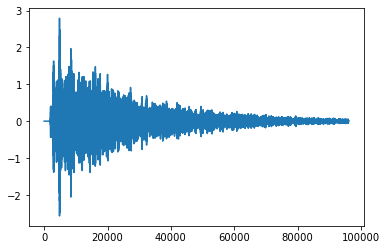

In [8]:
plt.plot((model.call(input_audio)).numpy()[0])

In [60]:
warnings.filterwarnings('ignore')
epochs = 100
spectral_losses = np.zeros(epochs)
start_time = time.time()
for epoch in range(epochs):
    
    print("\nStart of epoch %d" % (epoch,))
    
    with tf.GradientTape() as tape:
        output = model(input_audio)
        loss_value = spectral_loss(target_audio, output)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(
        "Training loss at epoch %d: %.4f"
        % (epoch, float(loss_value))
    )
    spectral_losses[epoch] = loss_value
    if epoch % 10 == 0:
        print("Saving checkpoint")
        checkpoint_manager.save()
print("Training took %d seconds" % (time.time() - start_time))


Start of epoch 0


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 0: 19.8981
Saving checkpoint

Start of epoch 1


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 1: 19.9192

Start of epoch 2


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 2: 19.9271

Start of epoch 3


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 3: 19.9148

Start of epoch 4


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 4: 19.9041

Start of epoch 5


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 5: 19.9076

Start of epoch 6


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 6: 19.8937

Start of epoch 7


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 7: 19.9192

Start of epoch 8


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 8: 19.9087

Start of epoch 9


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 9: 19.8981

Start of epoch 10


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 10: 19.8892
Saving checkpoint

Start of epoch 11


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 11: 19.8892

Start of epoch 12


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 12: 19.8851

Start of epoch 13


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 13: 19.8981

Start of epoch 14


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 14: 19.9087

Start of epoch 15


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 15: 19.9158

Start of epoch 16


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 16: 19.9192

Start of epoch 17


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 17: 19.9087

Start of epoch 18


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 18: 19.8946

Start of epoch 19


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 19: 19.8769

Start of epoch 20


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 20: 19.8981
Saving checkpoint

Start of epoch 21


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 21: 19.9192

Start of epoch 22


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 22: 19.9271

Start of epoch 23


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 23: 19.9244

Start of epoch 24


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 24: 19.9087

Start of epoch 25


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 25: 19.8981

Start of epoch 26


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 26: 19.8968

Start of epoch 27


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 27: 19.8850

Start of epoch 28


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 28: 19.8846

Start of epoch 29


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 29: 19.8769

Start of epoch 30


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 30: 19.8981
Saving checkpoint

Start of epoch 31


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 31: 19.9142

Start of epoch 32


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 32: 19.9217

Start of epoch 33


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 33: 19.9516

Start of epoch 34


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 34: 19.9633

Start of epoch 35


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 35: 19.9619

Start of epoch 36


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 36: 19.9619

Start of epoch 37


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 37: 19.9594

Start of epoch 38


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 38: 19.9633

Start of epoch 39


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 39: 19.9611

Start of epoch 40


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 40: 19.9633
Saving checkpoint

Start of epoch 41


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 41: 19.9732

Start of epoch 42


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 42: 19.9732

Start of epoch 43


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 43: 19.9497

Start of epoch 44


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 44: 19.9516

Start of epoch 45


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 45: 19.9590

Start of epoch 46


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 46: 19.9619

Start of epoch 47


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 47: 19.9688

Start of epoch 48


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 48: 19.9657

Start of epoch 49


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 49: 19.9743

Start of epoch 50


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 50: 19.9929
Saving checkpoint

Start of epoch 51


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 51: 19.9917

Start of epoch 52


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 52: 19.9904

Start of epoch 53


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 53: 20.0072

Start of epoch 54


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 54: 20.0147

Start of epoch 55


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 55: 20.0094

Start of epoch 56


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 56: 20.0109

Start of epoch 57


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 57: 19.9924

Start of epoch 58


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 58: 19.9857

Start of epoch 59


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 59: 19.9739

Start of epoch 60


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 60: 19.9688
Saving checkpoint

Start of epoch 61


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 61: 19.9636

Start of epoch 62


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 62: 19.9590

Start of epoch 63


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 63: 19.9633

Start of epoch 64


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 64: 19.9526

Start of epoch 65


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 65: 19.6842

Start of epoch 66


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 66: 19.8028

Start of epoch 67


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 67: 19.8198

Start of epoch 68


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 68: 19.8115

Start of epoch 69


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 69: 19.7442

Start of epoch 70


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 70: 19.7275
Saving checkpoint

Start of epoch 71


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 71: 19.6762

Start of epoch 72


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 72: 19.5679

Start of epoch 73


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 73: 19.8622

Start of epoch 74


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 74: 19.8571

Start of epoch 75


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 75: 19.8525

Start of epoch 76


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 76: 19.8452

Start of epoch 77


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 77: 19.8452

Start of epoch 78


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 78: 19.8525

Start of epoch 79


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 79: 19.8473

Start of epoch 80


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 80: 19.8298
Saving checkpoint

Start of epoch 81


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 81: 19.8264

Start of epoch 82


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 82: 19.8274

Start of epoch 83


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 83: 19.8214

Start of epoch 84


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 84: 19.8199

Start of epoch 85


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 85: 19.8080

Start of epoch 86


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 86: 19.8010

Start of epoch 87


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 87: 19.8551

Start of epoch 88


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 88: 19.7874

Start of epoch 89


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 89: 19.8522

Start of epoch 90


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 90: 19.8522
Saving checkpoint

Start of epoch 91


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 91: 19.8522

Start of epoch 92


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 92: 19.8522

Start of epoch 93


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 93: 19.8522

Start of epoch 94


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 94: 19.8522

Start of epoch 95


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 95: 19.8522

Start of epoch 96


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 96: 19.8522

Start of epoch 97


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 97: 19.8522

Start of epoch 98


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 98: 19.8522

Start of epoch 99


No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protocol specified
No protoco

Training loss at epoch 99: 19.8522
Training took 4653 seconds


Text(0.5, 1.0, 'Multi Scale Spectral loss')

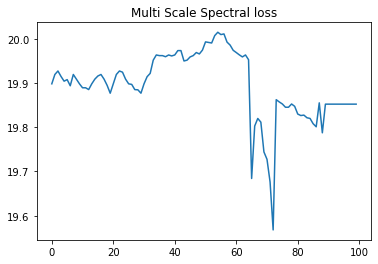

In [61]:
plt.plot(spectral_losses)
plt.title("Multi Scale Spectral loss")

In [62]:
output_audio = model(input_audio)
output_audio = output_audio.numpy()[0]
print(output_audio)

[ 0.          0.          0.         ... -0.00187515  0.00252069
 -0.00013808]


No protocol specified
No protocol specified


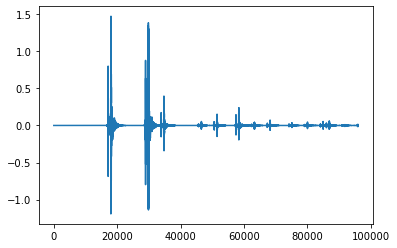

In [63]:
plt.plot(output_audio)

In [64]:
IPython.display.Audio(output_audio, rate=sample_rate)

In [65]:
IPython.display.Audio(target_audio, rate=sample_rate)